In [1]:
!pip install datasets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

# Feed Forward Network

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

plt.style.use("dark_background")

In [ ]:
crisis_df = pd.read_csv("crisis_aggregated_preprocessed.csv")
crisis_df.head()


,event,source,text,class_label,group,cleaned_text,normalized_text
0,disaster_events,drd-figureeight-multimedia,Approximately 100km long firebreaks have been ...,infrastructure_and_utilities_damage,train,approximately km long firebreaks have been con...,approximately km long firebreak constructed in...
1,2015_nepal_earthquake,crisisnlp-volunteers,God bless you... https://t.co/AnEy1ydkkz,not_humanitarian,train,god bless you,god bless
2,2014_california_earthquake,crisisnlp-cf,"RT @perreaux: Cracked wine casks, damaged hist...",infrastructure_and_utilities_damage,train,cracked wine casks damaged historical building...,cracked wine cask damaged historical building ...
3,2013_boston_bombings-ontopic,crisislext6,I'm really just excited for new undies and pin...,not_humanitarian,train,i m really just excited for new undies and pin...,really excited new undies pinkberry
4,2014_pakistan_floods,crisisnlp-cf,"Rescue effort expands in India, Pakistan as fl...",injured_or_dead_people,train,rescue effort expands in india pakistan as flo...,rescue effort expands india pakistan flood dea...


# Text Classification with Neural Networks

This code implements a text classification pipeline using a neural network with word embeddings.

## Data Preparation
- Loads text data (`crisis_df['normalized_text']`) and corresponding class labels
- Converts labels to one-hot encoded format
- Splits data into training (80%) and testing (20%) sets with stratification
- **Note**: Converts text data to strings to prevent errors (`X = crisis_df['normalized_text'].fillna("").astype(str)`)

## Text Processing
- Tokenizes text using Keras Tokenizer (vocabulary limited to 5,000 most common words)
- Converts text to sequences of integers
- Pads sequences to uniform length (200 tokens)

## Model Architecture
- Sequential model with the following layers:
  - Embedding layer (converts tokens to 128-dimensional vectors)
  - Flatten layer
  - Dense layer (256 units with ReLU activation)
  - Dropout layer (50% dropout for regularization)
  - Dense layer (128 units with ReLU activation)
  - Dropout layer (50%)
  - Output layer (softmax activation, one unit per class)
- Uses Adam optimizer (learning rate = 0.0005)
- Categorical cross-entropy loss function

## Training
- Trains for up to 30 epochs with early stopping
- Batch size of 16
- Monitors validation accuracy for early stopping (patience = 5)

## Evaluation
- Calculates test accuracy
- Generates classification report with precision, recall, and F1-score
- Visualizes training/validation accuracy and loss curves
- Creates a confusion matrix to show prediction patterns

## Troubleshooting
- Handles text data type issues by converting to strings
- Manages NaN values in the text data

In [ ]:
balanced_crisis_df = crisis_df.copy()

# Define the categories to merge
categories_to_merge = [
    'displaced_and_evacuations',
    'missing_and_found_people',
    'response_efforts'
]

# Create a new category name
new_category = 'crisis_response_and_displacement'

# Replace the old categories with the new one
balanced_crisis_df.loc[balanced_crisis_df['class_label'].isin(categories_to_merge), 'class_label'] = new_category

# Verify the new class distribution
class_distribution = balanced_crisis_df['class_label'].value_counts()
print(class_distribution)

class_label
not_humanitarian                       51584
donation_and_volunteering               7388
requests_or_needs                       6901
sympathy_and_support                    5104
infrastructure_and_utilities_damage     5050
affected_individual                     3510
caution_and_advice                      2990
injured_or_dead_people                  2773
crisis_response_and_displacement        2155
Name: count, dtype: int64


X_train shape: (69964, 200)
X_test shape: (17491, 200)
y_train shape: (69964, 9)
y_test shape: (17491, 9)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.6215 - loss: 1.2631 - val_accuracy: 0.7173 - val_loss: 0.8976
Epoch 2/4
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7226 - loss: 0.8429 - val_accuracy: 0.7592 - val_loss: 0.7595
Epoch 3/4
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7764 - loss: 0.6915 - val_accuracy: 0.7911 - val_loss: 0.6940
Epoch 4/4
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8157 - loss: 0.5780 - val_accuracy: 0.7963 - val_loss: 0.6915
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7922 - loss: 0.7265
Test accuracy: 0.7917


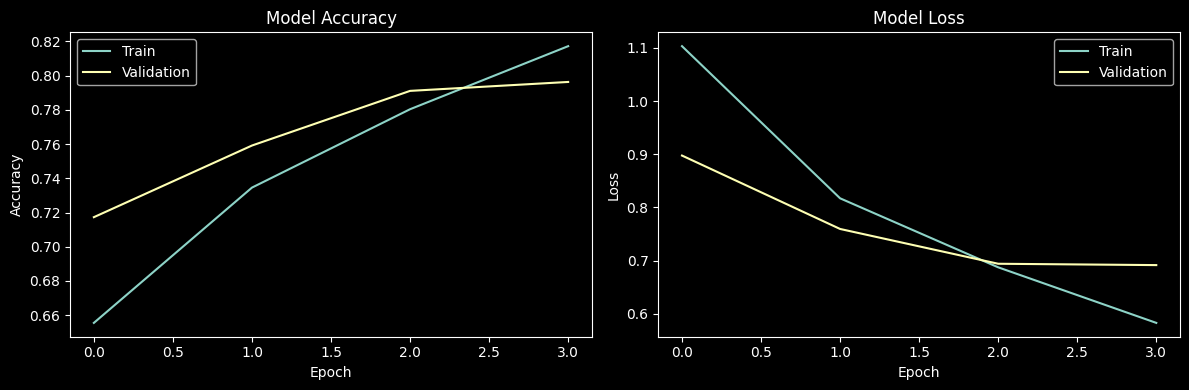

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
                                     precision    recall  f1-score   support

                affected_individual       0.76      0.50      0.60       702
                 caution_and_advice       0.55      0.45      0.50       598
   crisis_response_and_displacement       0.00      0.00      0.00       431
          donation_and_volunteering       0.57      0.81      0.67      1478
infrastructure_and_utilities_damage       0.50      0.56      0.53      1010
             injured_or_dead_people       0.73      0.54      0.62       554
                   not_humanitarian       0.88      0.92      0.90     10317
                  requests_or_needs       0.83      0.79      0.81      1380
               sympathy_and_support       0.72      0.55      0.62      1021

                           accuracy                           0.79     17491
                          macro avg       0.62      0.57      0.58     17491
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


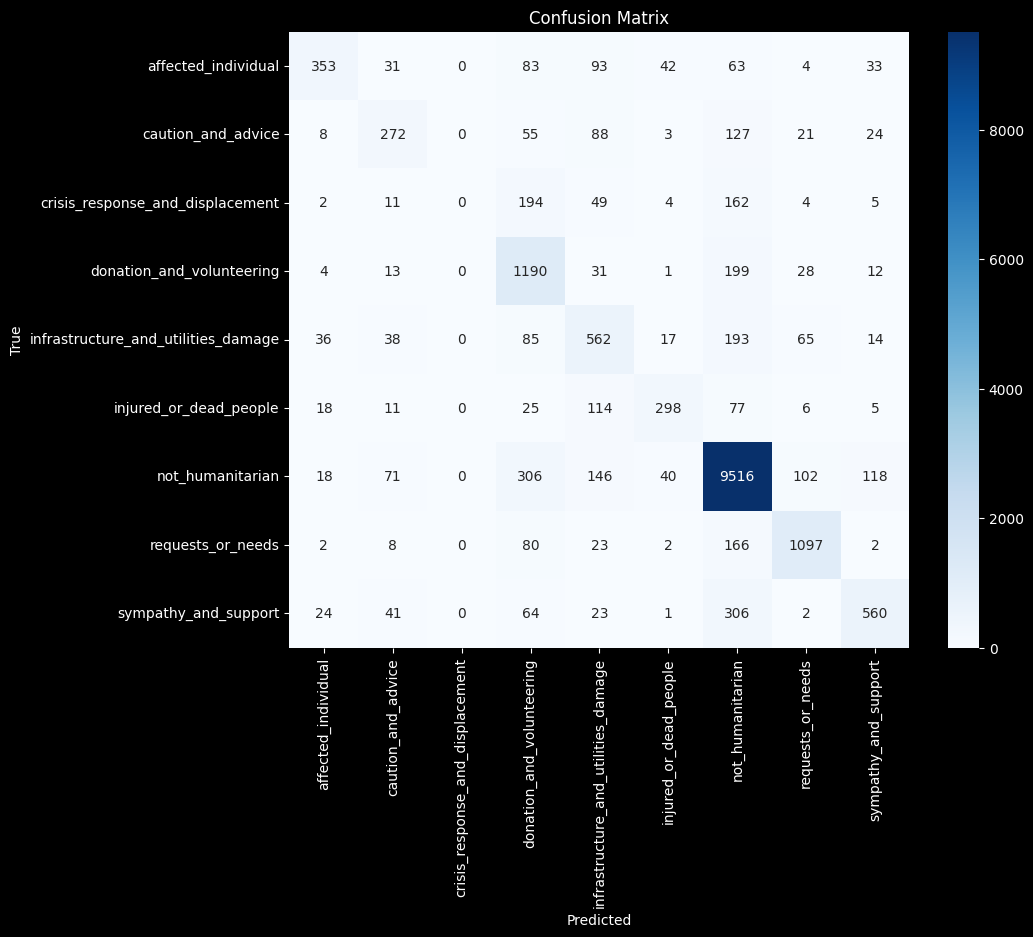

In [ ]:
X = balanced_crisis_df['normalized_text'].fillna("").astype(str)
y = balanced_crisis_df['class_label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Tokenize the text with a lower max_words value
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Print shapes to verify data
print(f"X_train shape: {X_train_pad.shape}")
print(f"X_test shape: {X_test_pad.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Feed Forward Neural Network with embedding
model = Sequential([
    # Add an embedding layer - this is key for text data
    Embedding(input_dim=max_words, output_dim=128),

    # Flatten the embedded sequences
    Flatten(),

    # First dense layer with a higher unit count
    Dense(256, activation='relu'),
    Dropout(0.5),  # Increase dropout for regularization

    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(y_categorical.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=4,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Predictions and classification report
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model


1. Parallel Convolutional Layers: We use four different filter sizes (2, 3, 4, and 5) to capture different n-gram patterns in the text. This helps the model recognize:
- 2-word phrases (bigrams)
- 3-word phrases (trigrams)
- 4-word phrases (4-grams)
- 5-word phrases (5-grams)
2. GlobalMaxPooling: For each convolutional filter, we apply global max pooling to extract the most important features.
3. Feature Concatenation: We combine all these pooled features to create a rich representation of the text that captures multiple levels of context.
4. Deep Dense Layers: Two dense layers with dropout for regularization help the model learn complex patterns in the concatenated features.

X_train shape: (69964, 200)
X_test shape: (17491, 200)
y_train shape: (69964, 9)
y_test shape: (17491, 9)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 200, 128)       │        640,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 199, 128)       │         32,896 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 198, 128)       │         49,280 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 197, 128)       │         65,664 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 196, 128)       │         82,048 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 128)            │              0 │ conv1d_4[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │        131,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 256)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         32,896 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128)            │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)     

 Total params: 1,035,273 (3.95 MB)

 Trainable params: 1,035,273 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6599 - loss: 1.1018 - val_accuracy: 0.8039 - val_loss: 0.6208
Epoch 2/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8223 - loss: 0.5707 - val_accuracy: 0.8210 - val_loss: 0.5727
Epoch 3/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8636 - loss: 0.4282 - val_accuracy: 0.8230 - val_loss: 0.5954
Epoch 4/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8957 - loss: 0.3209 - val_accuracy: 0.8186 - val_loss: 0.6465
Epoch 5/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9268 - loss: 0.2303 - val_accuracy: 0.8073 - val_loss: 0.7440
Epoch 6/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9452 - loss: 0.1732 - val_accuracy: 0.8038 - val_loss: 0.8729
Epoch 7/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9563 - loss: 0.1351 - val_accuracy: 0.8059 - val_loss: 1.0637
Epoch 8/25
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9680 - loss: 

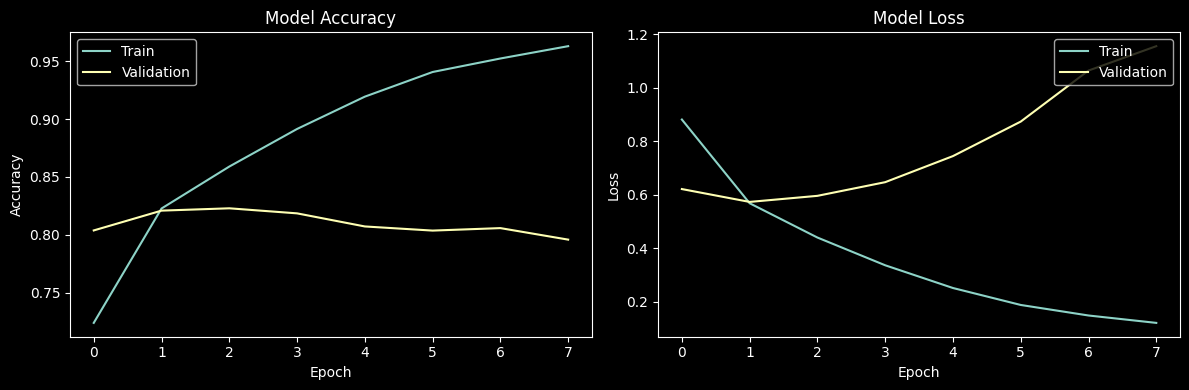

547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report:
                                     precision    recall  f1-score   support

                affected_individual       0.75      0.64      0.69       702
                 caution_and_advice       0.70      0.49      0.58       598
   crisis_response_and_displacement       0.44      0.36      0.39       431
          donation_and_volunteering       0.66      0.75      0.71      1478
infrastructure_and_utilities_damage       0.65      0.59      0.62      1010
             injured_or_dead_people       0.74      0.75      0.74       554
                   not_humanitarian       0.88      0.93      0.90     10317
                  requests_or_needs       0.87      0.77      0.82      1380
               sympathy_and_support       0.76      0.58      0.66      1021

                           accuracy                           0.82     17491
                          macro avg       0.72      0.65      0.68     17491
         

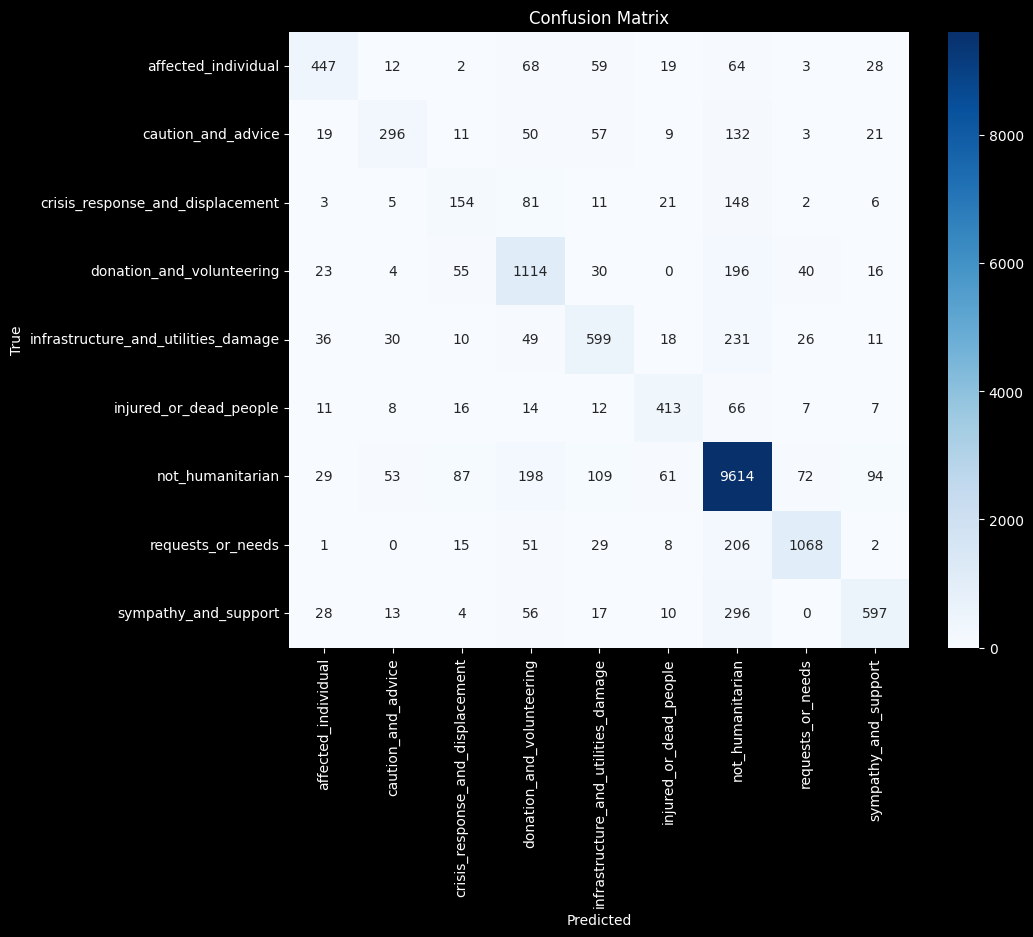

In [ ]:
X = balanced_crisis_df['normalized_text'].fillna("").astype(str)
y = balanced_crisis_df['class_label']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Tokenize the text
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Print shapes to verify data
print(f"X_train shape: {X_train_pad.shape}")
print(f"X_test shape: {X_test_pad.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Build multi-filter CNN model
# Input layer
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=max_words, output_dim=128)(inputs)

# Parallel convolutional layers with different filter sizes (2, 3, 4, 5)
conv1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation='relu')(embedding)
conv2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu')(embedding)
conv3 = Conv1D(filters=128, kernel_size=4, padding='valid', activation='relu')(embedding)
conv4 = Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu')(embedding)

# Max pooling for each convolutional layer
pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)
pool4 = GlobalMaxPooling1D()(conv4)

# Concatenate the pooled features
concatenated = Concatenate()([pool1, pool2, pool3, pool4])

# Dense layers
dense = Dense(256, activation='relu')(concatenated)
dropout1 = Dropout(0.5)(dense)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense2)
outputs = Dense(y_categorical.shape[1], activation='softmax')(dropout2)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train with early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Predictions and classification report
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Crisis Text Classification with DistilRoBERTa

This script implements a fine-tuned DistilRoBERTa transformer model for multi-class classification of crisis-related text data.

### Technical Details
- **Model Architecture**: DistilRoBERTa-base (smaller, faster version of RoBERTa) with a sequence classification head
- **Tokenization**: RoBERTa tokenizer with max sequence length of 256 tokens
- **Class Balancing**: Strategic merging of underrepresented categories ('displaced_and_evacuations', 'missing_and_found_people', 'response_efforts') into a unified 'crisis_response_and_displacement' class
- **Memory Optimization**: Implements gradient accumulation (4 steps) to enable training with limited VRAM
- **Hyperparameters**:
  - Learning rate: 2e-5 with AdamW optimizer
  - Batch size: 2 (physical) × 4 (accumulation) = 8 (effective)
  - Training epochs: 4 (max) with early stopping (patience=2)
  - Linear learning rate scheduler

### Implementation Features
- Custom PyTorch Dataset class (BBCDataset) for efficient data handling
- Three-way split: 60% training, 20% validation, 20% test (stratified)
- Gradient clipping (max_norm=1.0) to prevent exploding gradients
- Model checkpointing based on validation loss
- Performance visualization with confusion matrices and loss curves

### Evaluation & Output
- Classification metrics: Precision, recall, F1-score per class
- Serialized model artifacts: Saved model weights, tokenizer, and label encoder
- Confusion matrix visualization for error analysis
- Training/validation loss curves for convergence analysis

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import get_scheduler
import matplotlib.pyplot as plt
from torch.optim import AdamW
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import torch
import os

# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
crisis_df = pd.read_csv("crisis_aggregated_preprocessed.csv")
print(f"Dataset shape: {crisis_df.shape}")
print(crisis_df.head())

# Balance dataset
balanced_crisis_df = crisis_df.copy()

# Define the categories to merge
categories_to_merge = [
    'displaced_and_evacuations',
    'missing_and_found_people',
    'response_efforts'
]

# Create a new category name
new_category = 'crisis_response_and_displacement'

# Replace the old categories with the new one
balanced_crisis_df.loc[balanced_crisis_df['class_label'].isin(categories_to_merge), 'class_label'] = new_category

# Verify the new class distribution
class_distribution = balanced_crisis_df['class_label'].value_counts()
print(class_distribution)

# Check category distribution
print("\nCategory distribution:")
print(balanced_crisis_df['class_label'].value_counts())

# Encode labels
label_encoder = LabelEncoder()
balanced_crisis_df['label'] = label_encoder.fit_transform(balanced_crisis_df['class_label'])
print("\nEncoded labels:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

# Split the data - first into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    balanced_crisis_df['text'].values,
    balanced_crisis_df['label'].values,
    test_size=0.2,
    stratify=balanced_crisis_df['label'].values,
    random_state=42
)

# Then split the temp set into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original data
    stratify=y_temp,
    random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# Create PyTorch dataset
class BBCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):  # Reduced from 512
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Initialize tokenizer and model
print("\nLoading model and tokenizer...")
model_name = 'distilroberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)
model.to(device)

# Create data loaders
batch_size = 128

train_dataset = BBCDataset(X_train, y_train, tokenizer)
val_dataset = BBCDataset(X_val, y_val, tokenizer)
test_dataset = BBCDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training parameters
epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training function with gradient accumulation
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4):
    model.train()
    total_loss = 0

    optimizer.zero_grad()  # Zero gradients once at the beginning

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Get loss and divide by accumulation steps for gradient accumulation
        loss = outputs.loss / accumulation_steps
        total_loss += loss.item() * accumulation_steps  # Multiply back for logging

        # Backward pass
        loss.backward()

        # Update weights only after accumulating gradients for several steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Report loss value
        progress_bar.set_postfix({'loss': loss.item() * accumulation_steps})

    # Calculate average loss over all batches
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return predictions, actual_labels

# Training loop
print("\nTraining RoBERTa model:")
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 2  # For early stopping
patience_counter = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    print(f"Training loss: {train_loss}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = (np.array(val_preds) == np.array(val_labels)).mean() * 100
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model for final evaluation
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss for final evaluation.")

# Final evaluation
print("\nFinal evaluation:")
predictions, actual_labels = evaluate(model, test_loader, device)

# Convert numerical labels back to original categories
predicted_categories = label_encoder.inverse_transform(predictions)
actual_categories = label_encoder.inverse_transform(actual_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_categories, predicted_categories))

# Display confusion matrix
cm = confusion_matrix(actual_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

# Example prediction function
def predict_category(text, model, tokenizer, label_encoder, device, max_length=512):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

    predicted_label = preds.item()
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_category

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.close()

# Save the model
output_dir = './roberta_bbc_model/'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save the label encoder
import pickle
with open(f"{output_dir}label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(f"Model saved to {output_dir}")

# Test the model with some examples
print("\nTesting with examples:")
test_examples = X_test[:3]
for text in test_examples:
    category = predict_category(text, model, tokenizer, label_encoder, device)
    print(f"\nText: {text[:150]}...")
    print(f"Predicted category: {category}")

Using device: cuda
Dataset shape: (87455, 7)
                          event                      source  \
0               disaster_events  drd-figureeight-multimedia   
1         2015_nepal_earthquake        crisisnlp-volunteers   
2    2014_california_earthquake                crisisnlp-cf   
3  2013_boston_bombings-ontopic                 crisislext6   
4          2014_pakistan_floods                crisisnlp-cf   

                                                text  \
0  Approximately 100km long firebreaks have been ...   
1           God bless you... https://t.co/AnEy1ydkkz   
2  RT @perreaux: Cracked wine casks, damaged hist...   
3  I'm really just excited for new undies and pin...   
4  Rescue effort expands in India, Pakistan as fl...   

                           class_label  group  \
0  infrastructure_and_utilities_damage  train   
1                     not_humanitarian  train   
2  infrastructure_and_utilities_damage  train   
3                     not_humanitarian  tra

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training RoBERTa model:

Epoch 1/4


Training loss: 1.0696099849735818


Validation loss: 0.6283, Validation accuracy: 80.02%
New best model saved with validation loss: 0.6283

Epoch 2/4


Training loss: 0.5726854386126122


Validation loss: 0.5191, Validation accuracy: 83.32%
New best model saved with validation loss: 0.5191

Epoch 3/4


Training loss: 0.48002620848213756


Validation loss: 0.4740, Validation accuracy: 84.72%
New best model saved with validation loss: 0.4740

Epoch 4/4


Training loss: 0.42460233398327013


Validation loss: 0.4382, Validation accuracy: 85.56%
New best model saved with validation loss: 0.4382
Loaded best model based on validation loss for final evaluation.

Final evaluation:



Classification Report:
                                     precision    recall  f1-score   support

                affected_individual       0.69      0.75      0.72       702
                 caution_and_advice       0.73      0.65      0.69       598
   crisis_response_and_displacement       0.54      0.34      0.41       431
          donation_and_volunteering       0.75      0.83      0.79      1478
infrastructure_and_utilities_damage       0.66      0.75      0.70      1010
             injured_or_dead_people       0.78      0.75      0.76       554
                   not_humanitarian       0.92      0.93      0.93     10317
                  requests_or_needs       0.95      0.85      0.90      1380
               sympathy_and_support       0.75      0.73      0.74      1021

                           accuracy                           0.86     17491
                          macro avg       0.75      0.73      0.74     17491
                       weighted avg       0.86    

In [ ]:
category = predict_category("The new Iphone 17 has a 48mp camera", model, tokenizer, label_encoder, device)
print(category)
category = predict_category("Carole and Mike are still missing, please help!", model, tokenizer, label_encoder, device)
print(category)

not_humanitarian
requests_or_needs


## Specs
- T4 GPU: ~14GB
- System RAM: ~4GB


# Comparing DistilRoBERTa vs. Standard RoBERTa
DistilRoBERTa is a lightweight version of RoBERTa created through knowledge distillation, where a smaller "student" model learns to mimic a larger "teacher" model. Here are the key differences:

## Architecture Differences

- Size: DistilRoBERTa has ~82 million parameters compared to RoBERTa-base's ~125 million parameters (35% reduction)
- Layers: 6 transformer layers in DistilRoBERTa vs. 12 layers in RoBERTa
- Attention Heads: Typically fewer attention heads per layer
- Token Type Embeddings: Removed in DistilRoBERTa (were used in RoBERTa for next sentence prediction tasks)

## Performance Tradeoffs

- Speed: DistilRoBERTa is approximately 2x faster for both training and inference
- Memory Usage: Requires 40-45% less GPU memory during training and inference
- Accuracy: Retains about 95% of RoBERTa's performance on most NLP benchmarks
- Convergence: Often requires slightly more training steps to reach optimal performance

## Training Method
DistilRoBERTa is trained using a triple loss function:

- Distillation Loss: Matches the student's output probabilities to the teacher's
- Masked Language Modeling Loss: Standard MLM objective used in BERT/RoBERTa
- Cosine Embedding Loss: Aligns hidden state representations between models

## Practical Implications
In the crisis classification code, using DistilRoBERTa enables:

- Training on GPUs with less VRAM (combined with gradient accumulation)
- Faster iteration during development
- Reduced inference latency for production deployment
- Lower computational costs while maintaining reasonable accuracy

The tradeoff is generally worthwhile for most practical applications where the slight decrease in accuracy is acceptable for the substantial gains in efficiency and resource utilization.

# ⚾⚾⚾⚾⚾RoBERTa⚾⚾⚾⚾⚾

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import get_scheduler
import matplotlib.pyplot as plt
from torch.optim import AdamW
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import torch
import os

# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
crisis_df = pd.read_csv("crisis_aggregated_preprocessed.csv")
print(f"Dataset shape: {crisis_df.shape}")
print(crisis_df.head())

# Balance dataset
balanced_crisis_df = crisis_df.copy()

# Define the categories to merge
categories_to_merge = [
    'displaced_and_evacuations',
    'missing_and_found_people',
    'response_efforts'
]

# Create a new category name
new_category = 'crisis_response_and_displacement'

# Replace the old categories with the new one
balanced_crisis_df.loc[balanced_crisis_df['class_label'].isin(categories_to_merge), 'class_label'] = new_category

# Verify the new class distribution
class_distribution = balanced_crisis_df['class_label'].value_counts()
print(class_distribution)

# Check category distribution
print("\nCategory distribution:")
print(balanced_crisis_df['class_label'].value_counts())

# Encode labels
label_encoder = LabelEncoder()
balanced_crisis_df['label'] = label_encoder.fit_transform(balanced_crisis_df['class_label'])
print("\nEncoded labels:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

# Split the data - first into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    balanced_crisis_df['text'].values,
    balanced_crisis_df['label'].values,
    test_size=0.2,
    stratify=balanced_crisis_df['label'].values,
    random_state=42
)

# Then split the temp set into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original data
    stratify=y_temp,
    random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# Create PyTorch dataset
class BBCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Initialize tokenizer and model
print("\nLoading model and tokenizer...")
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)
model.to(device)

# Create data loaders
batch_size = 32

train_dataset = BBCDataset(X_train, y_train, tokenizer)
val_dataset = BBCDataset(X_val, y_val, tokenizer)
test_dataset = BBCDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training parameters
epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training function with gradient accumulation
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4):
    model.train()
    total_loss = 0

    optimizer.zero_grad()  # Zero gradients once at the beginning

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Get loss and divide by accumulation steps for gradient accumulation
        loss = outputs.loss / accumulation_steps
        total_loss += loss.item() * accumulation_steps  # Multiply back for logging

        # Backward pass
        loss.backward()

        # Update weights only after accumulating gradients for several steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Report loss value
        progress_bar.set_postfix({'loss': loss.item() * accumulation_steps})

    # Calculate average loss over all batches
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return predictions, actual_labels

# Training loop
print("\nTraining RoBERTa model:")
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 2  # For early stopping
patience_counter = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    print(f"Training loss: {train_loss}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = (np.array(val_preds) == np.array(val_labels)).mean() * 100
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model for final evaluation
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss for final evaluation.")

# Final evaluation
print("\nFinal evaluation:")
predictions, actual_labels = evaluate(model, test_loader, device)

# Convert numerical labels back to original categories
predicted_categories = label_encoder.inverse_transform(predictions)
actual_categories = label_encoder.inverse_transform(actual_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_categories, predicted_categories))

# Display confusion matrix
cm = confusion_matrix(actual_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

# Example prediction function
def predict_category(text, model, tokenizer, label_encoder, device, max_length=512):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

    predicted_label = preds.item()
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_category

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.close()

# Save the model
output_dir = './roberta_bbc_model/'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save the label encoder
import pickle
with open(f"{output_dir}label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(f"Model saved to {output_dir}")

# Test the model with some examples
print("\nTesting with examples:")
test_examples = X_test[:3]
for text in test_examples:
    category = predict_category(text, model, tokenizer, label_encoder, device)
    print(f"\nText: {text[:150]}...")
    print(f"Predicted category: {category}")

Using device: cuda
Dataset shape: (87455, 7)
                          event                      source  \
0               disaster_events  drd-figureeight-multimedia   
1         2015_nepal_earthquake        crisisnlp-volunteers   
2    2014_california_earthquake                crisisnlp-cf   
3  2013_boston_bombings-ontopic                 crisislext6   
4          2014_pakistan_floods                crisisnlp-cf   

                                                text  \
0  Approximately 100km long firebreaks have been ...   
1           God bless you... https://t.co/AnEy1ydkkz   
2  RT @perreaux: Cracked wine casks, damaged hist...   
3  I'm really just excited for new undies and pin...   
4  Rescue effort expands in India, Pakistan as fl...   

                           class_label  group  \
0  infrastructure_and_utilities_damage  train   
1                     not_humanitarian  train   
2  infrastructure_and_utilities_damage  train   
3                     not_humanitarian  tra

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training RoBERTa model:

Epoch 1/4


Training loss: 0.6720589547168191


Validation loss: 0.4598, Validation accuracy: 85.18%
New best model saved with validation loss: 0.4598

Epoch 2/4


Training loss: 0.3975559061188705


Validation loss: 0.3838, Validation accuracy: 87.81%
New best model saved with validation loss: 0.3838

Epoch 3/4


Training loss: 0.3124666854489322


Validation loss: 0.3915, Validation accuracy: 87.51%
Validation loss did not improve. Patience: 1/2

Epoch 4/4


Training:  57%|█████▋    | 931/1640 [20:21<15:26,  1.31s/it, loss=0.357]

- System RAM: 3.6GB
- GPU RAM: 8.2GB
- BUT WITH HALF OF THE BATCH SIZE as distilRoBERTa

2 epcohs are enough?

# Zero-Shot Classification with comprehend_it-base & DeBERTa-v3-large-mnli-fever-anli-ling-wanli

In [4]:
from sklearn.metrics import classification_report
from transformers import pipeline
from datasets import Dataset
from tqdm import tqdm
import pandas as pd
import torch

# --- Configuration ---
MODEL_NAME = "knowledgator/comprehend_it-base"
CSV_FILE = "crisis_aggregated_preprocessed.csv"
TEXT_COLUMN = "text"
LABEL_COLUMN = "class_label"
BATCH_SIZE = 128
SAMPLE_SIZE = 10000
RANDOM_SEED = 42

# --- Load the dataset ---
try:
    crisis_df = pd.read_csv(CSV_FILE)

    categories_to_merge = [
    'displaced_and_evacuations',
    'missing_and_found_people',
    'response_efforts'
    ]
    balanced_crisis_df = crisis_df.copy()
    balanced_crisis_df.loc[balanced_crisis_df['class_label'].isin(categories_to_merge), 'class_label'] = 'crisis_response_and_displacement'

    sampled_df = balanced_crisis_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)

    print(f"Dataset loaded successfully. Shape: {sampled_df.shape}")
    # Verify columns exist
    if TEXT_COLUMN not in sampled_df.columns or LABEL_COLUMN not in sampled_df.columns:
        raise ValueError(f"CSV must contain '{TEXT_COLUMN}' and '{LABEL_COLUMN}' columns.")
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_FILE}")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Get unique categories
categories = sampled_df[LABEL_COLUMN].unique().tolist()

# --- Convert to Dataset ---
dataset = Dataset.from_pandas(sampled_df)

# --- Initialize classifier ---
device_index = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'cuda:' + str(device_index) if device_index >= 0 else 'cpu'}")

try:
    classifier = pipeline(
        "zero-shot-classification",
        model=MODEL_NAME,
        device=device_index,  # Use GPU if available (0), otherwise CPU (-1)
        torch_dtype=torch.float16
    )
    print(f"Pipeline initialized with model: {MODEL_NAME}")
except Exception as e:
    print(f"Error initializing pipeline: {e}")
    print("Ensure you have 'transformers' and potentially 'torch' installed correctly.")
    print("You might need to install sentencepiece: pip install sentencepiece")
    exit()

# --- Define prediction function ---
def predict_zero_shot(examples):
    results = classifier(examples[TEXT_COLUMN], categories)
    return {"predicted_label": [r['labels'][0] for r in results]}

# --- Run inference using dataset map ---
print(f"Starting zero-shot classification for {len(dataset)} examples...")
try:
    # Process using Dataset.map
    dataset = dataset.map(
        predict_zero_shot,
        batched=True,
        batch_size=BATCH_SIZE,
    )
    print("Inference complete.")
except Exception as e:
    print(f"Error during classification: {e}")
    exit()

# --- Evaluate results ---
predictions = dataset["predicted_label"]
true_labels = dataset[LABEL_COLUMN]

print("\nClassification Report (Zero-Shot):")
if len(true_labels) == len(predictions):
    print(classification_report(true_labels, predictions, target_names=categories))
else:
    print(f"Error: Mismatch in length between true labels ({len(true_labels)}) and predictions ({len(predictions)}).")

Dataset loaded successfully. Shape: (10000, 7)
Using device: cuda:0


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0


Pipeline initialized with model: knowledgator/comprehend_it-base
Starting zero-shot classification for 10000 examples...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Inference complete.

Classification Report (Zero-Shot):
                                     precision    recall  f1-score   support

               sympathy_and_support       0.02      0.05      0.02       419
                   not_humanitarian       0.16      0.39      0.23       333
                  requests_or_needs       0.07      0.43      0.12       236
                affected_individual       0.29      0.05      0.08       806
infrastructure_and_utilities_damage       0.55      0.36      0.43       574
   crisis_response_and_displacement       0.28      0.54      0.37       312
                 caution_and_advice       0.88      0.29      0.44      5895
             injured_or_dead_people       0.19      0.34      0.24       823
          donation_and_volunteering       0.23      0.59      0.33       602

                           accuracy                           0.30     10000
                          macro avg       0.29      0.34      0.25     10000
                  

Such compute such wow
Classifying:   1%|▏         | 128/10000 [01:16<1:37:42,  1.68text/s]

In [3]:
from sklearn.metrics import classification_report
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import torch

# --- Configuration ---
MODEL_NAME = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
CSV_FILE = "crisis_aggregated_preprocessed.csv"
TEXT_COLUMN = "text"
LABEL_COLUMN = "class_label"
BATCH_SIZE = 128
SAMPLE_SIZE = 10000
RANDOM_SEED = 42

# --- Load the dataset ---
try:
    crisis_df = pd.read_csv(CSV_FILE)

    categories_to_merge = [
    'displaced_and_evacuations',
    'missing_and_found_people',
    'response_efforts'
    ]
    balanced_crisis_df = crisis_df.copy()
    balanced_crisis_df.loc[balanced_crisis_df['class_label'].isin(categories_to_merge), 'class_label'] = 'crisis_response_and_displacement'

    sampled_df = balanced_crisis_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)

    print(f"Dataset loaded successfully. Shape: {sampled_df.shape}")
    # Verify columns exist
    if TEXT_COLUMN not in sampled_df.columns or LABEL_COLUMN not in sampled_df.columns:
        raise ValueError(f"CSV must contain '{TEXT_COLUMN}' and '{LABEL_COLUMN}' columns.")
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_FILE}")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

categories = sampled_df[LABEL_COLUMN].unique().tolist()

# --- Initialize classifier ---
device_index = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'cuda:' + str(device_index) if device_index >= 0 else 'cpu'}")

try:
    classifier = pipeline(
        "zero-shot-classification",
        model=MODEL_NAME,
        device=device_index  # Use GPU if available (0), otherwise CPU (-1)
    )
    print(f"Pipeline initialized with model: {MODEL_NAME}")
except Exception as e:
    print(f"Error initializing pipeline: {e}")
    print("Ensure you have 'transformers' and potentially 'torch' installed correctly.")
    print("You might need to install sentencepiece: pip install sentencepiece")
    exit()

texts = sampled_df[TEXT_COLUMN].tolist()
true_labels = sampled_df[LABEL_COLUMN].tolist()

# --- Run batched inference with progress bar ---
print(f"Starting zero-shot classification for {len(texts)} examples...")
try:
    # Process in batches with progress bar
    predictions = []
    # Calculate number of batches
    num_batches = (len(texts) + BATCH_SIZE - 1) // BATCH_SIZE

    # Create progress bar for batch processing
    with tqdm(total=len(texts), desc="Classifying", unit="text") as pbar:
        for i in range(0, len(texts), BATCH_SIZE):
            batch_texts = texts[i:i+BATCH_SIZE]
            batch_results = classifier(batch_texts, categories)

            # Extract predictions for this batch
            batch_predictions = [r['labels'][0] for r in batch_results]
            predictions.extend(batch_predictions)

            # Update progress bar with the number of processed items
            pbar.update(len(batch_texts))

    print("Inference complete.")
except Exception as e:
    print(f"Error during classification: {e}")
    exit()

print("\nClassification Report (Zero-Shot):")
if len(true_labels) == len(predictions):
    print(classification_report(true_labels, predictions, target_names=categories))
else:
    print(f"Error: Mismatch in length between true labels ({len(true_labels)}) and predictions ({len(predictions)}).")

Dataset loaded successfully. Shape: (10000, 7)
Using device: cuda:0


Device set to use cuda:0


Pipeline initialized with model: MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli
Starting zero-shot classification for 10000 examples...


Classifying: 100%|██████████| 10000/10000 [1:06:06<00:00,  2.52text/s]

Inference complete.

Classification Report (Zero-Shot):
                                     precision    recall  f1-score   support

               sympathy_and_support       0.04      0.09      0.06       419
                   not_humanitarian       0.11      0.87      0.19       333
                  requests_or_needs       0.16      0.14      0.15       236
                affected_individual       0.38      0.20      0.26       806
infrastructure_and_utilities_damage       0.53      0.35      0.42       574
   crisis_response_and_displacement       0.28      0.80      0.42       312
                 caution_and_advice       0.92      0.26      0.41      5895
             injured_or_dead_people       0.43      0.30      0.35       823
          donation_and_volunteering       0.19      0.74      0.30       602

                           accuracy                           0.32     10000
                          macro avg       0.34      0.42      0.28     10000
                  